# Modules to download

In [11]:
# !pip install antspyx
# !pip install SimpleITK
# !pip install helpers
# !pip install antspyx antspynet

In [1]:
# Importation for modules.
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import cv2
from scipy.ndimage import binary_fill_holes
from skimage.morphology import remove_small_objects, convex_hull_image
from skimage.segmentation import active_contour
from skimage.filters import gaussian
import ants
import SimpleITK as sitk
from helpers import *
from antspynet.utilities import brain_extraction
import os
import csv

MAPPING DEMOGRAPHIC DATA TO DATASET

In [2]:
Dataset_folder = "../oasis_db/OAS2_RAW_PART2/OAS2_RAW_PART2" #replace with path t your dataset folder
if not os.path.exists(Dataset_folder):
        print([])  

nifti_files = []
for item in os.listdir(Dataset_folder):
    item_path = os.path.join(Dataset_folder, item)
    if os.path.isdir(item_path):  # Check if it's a directory
        nifti_files.append(item)



header = None #storing header to write to new cleaned csv file
demographic_mri_ids = [] #stores mri mri_ids in demographic data
demographic_data = "oasis_longitudinal_demographics-8d83e569fa2e2d30.csv" #file path of uncleaned data
with open(demographic_data, 'r', newline='', encoding='utf-8') as csvfile:
    reader = csv.reader(csvfile)
    header = next(reader)  # Read header
    column_index = 1  # index of "mri id" column

    for row in reader:
        try:
            demographic_mri_ids.append(row[column_index])
        except IndexError:
            print(f"Warning: Row has fewer columns than expected.")  # Handle missing data
print()
print(len(demographic_mri_ids))
print(len(nifti_files))

#finding intersection
demographic_mri_ids_set = set(demographic_mri_ids)
nifti_files_set = set(nifti_files)
final_data = demographic_mri_ids_set.intersection(nifti_files_set)
print(len(final_data) == len(nifti_files)) # len same as nifti files therfore all demographics data for nifti files available


#creating new csv with cleaned data
filtered_rows = []
with open(demographic_data, 'r', newline='', encoding='utf-8') as csvfile:
    reader = csv.reader(csvfile)
    header = next(reader)  # Read header (if present)
    column_index = 1  # index of "mri id" column

    for row in reader:
        try:
            if row[column_index] in final_data:
                filtered_rows.append(row)
        except IndexError:
            print(f"Warning: Row has fewer columns than expected.")  # Handle missing data

output_filepath = "cleaned_demographic_data"
with open(output_filepath, 'w', newline='', encoding='utf-8') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(header)
    writer.writerows(filtered_rows)
    print(f"Filtered data written to: {output_filepath}")



373
164
True
Filtered data written to: cleaned_demographic_data


In [3]:
# Function to display nifti files
from ipywidgets import interact
def explore_3D_array(arr: np.ndarray, cmap: str='gray'):
    def fn(SLICE):
        plt.figure(figsize=(7,7))
        plt.axis('off')
        plt.imshow(arr[SLICE,:,:], cmap=cmap)

    interact(fn, SLICE=(0, arr.shape[0]-1))

def add_suffix_to_filename(filename: str, suffix: str) ->str:
    if filename.endswith('.nifti.hdr'):
        result = filename.replace('.nifti.hdr', f'_{suffix}.nifti.hdr')
        return result
    else:
        raise RuntimeError('filename with unknown ext')

def rescale_linear(array: np.ndarray, new_min: int, new_max: int):
  minimum, maximum = np.min(array), np.max(array)
  m = (new_max - new_min) / (maximum - minimum)
  b = new_min - m * minimum
  return m * array + b

def explore_3D_array_with_mask_contour(arr: np.ndarray, mask: np.ndarray, thickness: int = 1):
  _arr = rescale_linear(arr,0,1)
  _mask = rescale_linear(mask,0,1)
  _mask = _mask.astype(np.uint8)

  def fn(SLICE):
    arr_rgb = cv2.cvtColor(_arr[SLICE, :, :], cv2.COLOR_GRAY2RGB)
    contours, _ = cv2.findContours(_mask[SLICE, :, :], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    arr_with_contours = cv2.drawContours(arr_rgb, contours, -1, (0,1,0), thickness)

    plt.figure(figsize=(7,7))
    plt.imshow(arr_with_contours)

  interact(fn, SLICE=(0, arr.shape[0]-1))

# Change this cell according to your directory

In [ ]:
def extracting_brain(img_path):
    ant_img = ants.image_read(img_path, reorient='RAS')
    imp_image=ant_img.numpy()[(ant_img.shape[0]//2)-10:(ant_img.shape[0]//2)+10]
    explore_3D_array(arr=imp_image, cmap='nipy_spectral')
    # prob_brain_mask = brain_extraction(ant_img, modality="t1", verbose=True)
    # brain_mask = ants.get_mask(prob_brain_mask, low_thresh=0.5)
    # explore_3D_array_with_mask_contour(ant_img.numpy(), brain_mask.numpy())
    # # Apply the mask
    # masked = ants.mask_image(ant_img, brain_mask)

    # # Convert to NumPy array
    # final_mask = masked.numpy()


    # # Convert back to ANTs image (to preserve metadata)
    # rotated_masked_ant = ants.from_numpy(final_mask, origin=masked.origin, spacing=masked.spacing, direction=masked.direction)

    # # Visualize the rotated image
    # explore_3D_array(final_mask, cmap='gray')
    # final_mask.shape
    # return final_mask


In [13]:
def preprocess_mri_image(img_array):
    """
    Preprocess an MRI image with the following steps:
    1. Convert to grayscale (if needed)
    2. Apply CLAHE for contrast enhancement
    3. Apply Gaussian blur
    4. Apply Median blur for noise reduction
    5. Apply sharpening
    6. Apply Non-Local Means Denoising
    7. Add salt-and-pepper noise at the end

    :param img_array: NumPy array of the MRI image
    :return: Processed NumPy array
    """
    img_array
    if len(img_array.shape) == 3:  # Check if it's a 3D array (e.g., 128, 256, 256)
        processed_slices = []
        for i in range((img_array.shape[0]//2)-10,(img_array.shape[0]//2)+10):  # Iterate through each slice
            slice_img = img_array[i]
            processed_slices.append(process_single_slice(slice_img))
        return np.array(processed_slices)

    else:
        return process_single_slice(img_array)

def process_single_slice(slice_img):
    """
    Process a single 2D slice of the MRI image.
    """
    # Ensure image is single-channel grayscale
    if len(slice_img.shape) == 3 and slice_img.shape[-1] == 3:  # Check if RGB
        slice_img = cv2.cvtColor(slice_img, cv2.COLOR_BGR2GRAY)

    # Normalize and convert to uint8
    slice_img = cv2.normalize(slice_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Apply CLAHE (Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    slice_img = clahe.apply(slice_img)

    # Apply Gaussian Blur
    slice_img = cv2.GaussianBlur(slice_img, (5, 5), 0)

    # Apply Median Blur
    slice_img = cv2.medianBlur(slice_img, 5)

    # Apply sharpening filter
    sharpen_kernel = np.array([[0, -1, 0],
                               [-1, 5, -1],
                               [0, -1, 0]])
    slice_img = cv2.filter2D(slice_img, -1, sharpen_kernel)

    # Apply Non-Local Means Denoising
    slice_img = cv2.fastNlMeansDenoising(slice_img, None, h=10, templateWindowSize=7, searchWindowSize=21)

    # Add Salt-and-Pepper Noise
    slice_img = add_salt_and_pepper(slice_img)

    return slice_img

def add_salt_and_pepper(img, salt_prob=0.02, pepper_prob=0.02):
    """
    Function to add salt-and-pepper noise to an image.
    """
    noisy_img = img.copy()
    num_salt = int(salt_prob * img.size)
    num_pepper = int(pepper_prob * img.size)

    # Add salt (white pixels)
    coords = [np.random.randint(0, i - 1, num_salt) for i in img.shape]
    noisy_img[tuple(coords)] = 255

    # Add pepper (black pixels)
    coords = [np.random.randint(0, i - 1, num_pepper) for i in img.shape]
    noisy_img[tuple(coords)] = 0

    return noisy_img

In [27]:
# Assuming final_mask is a 3D array with shape (128, 256, 256)

final_mask = extracting_brain(r"C:\Users\moksh\OneDrive\Desktop\Alzeimers\oasis_db\OAS2_RAW_PART2\OAS2_RAW_PART2\OAS2_0112_MR1\RAW\mpr-3.nifti.hdr")
# processed_img = preprocess_mri_image(final_mask)
# print("completly preprocessed image")
# explore_3D_array(processed_img)

NameError: name 'any_img' is not defined

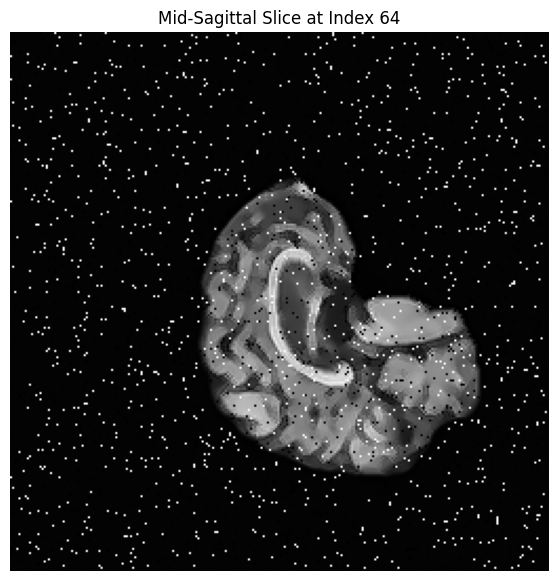

In [7]:
mid_sagittal_index = processed_img.shape[0] // 2

# Step 2: Extract the mid-sagittal slice
mid_sagittal_slice = processed_img[mid_sagittal_index, :, :]

# Step 3: Display the mid-sagittal slice
plt.figure(figsize=(7, 7))
plt.imshow(mid_sagittal_slice, cmap='gray')
plt.title(f"Mid-Sagittal Slice at Index {mid_sagittal_index}")
plt.axis('off')  # Turn off axes for clarity
plt.show()

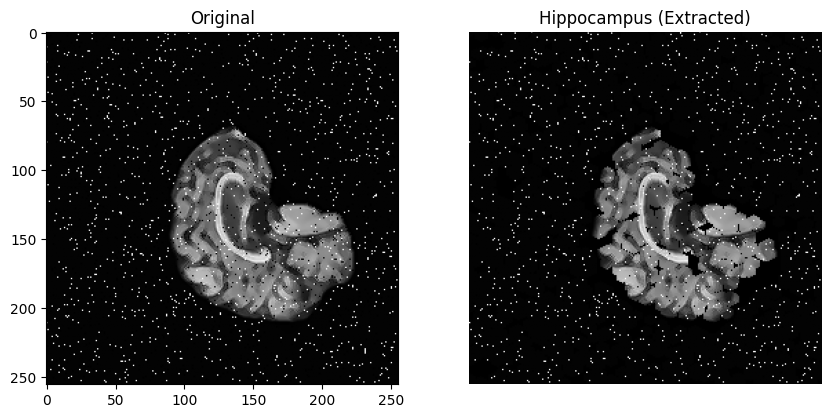

In [8]:
from skimage import exposure


# Load  mid-sagittal slice
mid_sagittal_slice = processed_img[mid_sagittal_index, :, :]

#  Preprocessing 
equalized = exposure.equalize_hist(mid_sagittal_slice)

# 2. Thresholding to isolate brain structures
_, thresh = cv2.threshold((equalized * 255).astype(np.uint8), 100, 255, cv2.THRESH_BINARY)

# 3. Clean up with morphology
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# --- Hippocampus Extraction (Example Logic) ---
# 4. Assume the hippocampus is a bright region in the mid-sagittal slice
hippo_mask = cv2.inRange(opened, 200, 255)  

# --- Apply Mask ---
# Convert mask to binary (0 or 1)
hippo_mask_binary = (hippo_mask > 0).astype(np.uint8)

# Extract hippocampus
hippocampus = mid_sagittal_slice * hippo_mask_binary


plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(mid_sagittal_slice, cmap='gray'), plt.title('Original')
plt.subplot(122), plt.imshow(hippocampus, cmap='gray'), plt.title('Hippocampus (Extracted)')
plt.axis('off')
plt.show()

Optimal n_components to retain 95% variance: 123


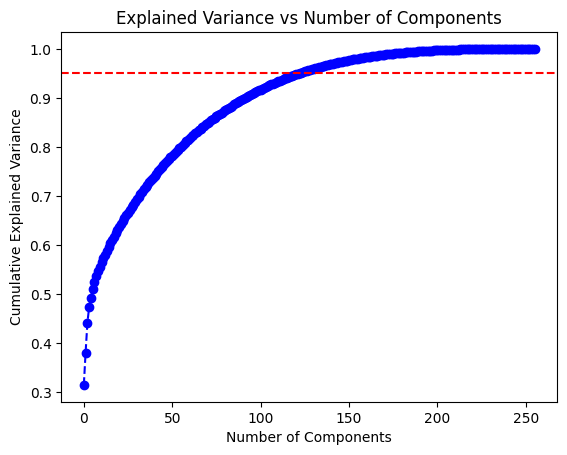

In [9]:
from sklearn.decomposition import PCA
h, w = hippocampus.shape
image_reshaped = hippocampus.reshape(h, w)


pca = PCA()
pca.fit(image_reshaped)

# Compute cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the smallest number of components to retain ~95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Optimal n_components to retain 95% variance: {n_components_95}")

# Plot explained variance
plt.plot(cumulative_variance, marker='o', linestyle='--', color='b')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs Number of Components")
plt.show()

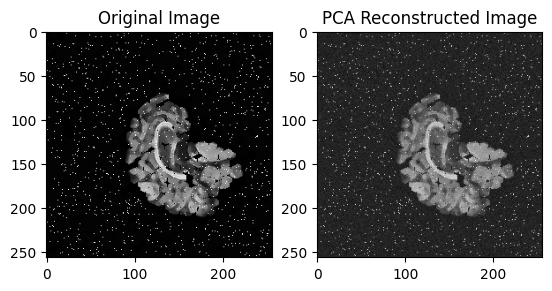

In [10]:
from sklearn.decomposition import PCA
hippocampus=hippocampus/255.0
pca = PCA(n_components=115) 
transformed_image=pca.fit_transform(hippocampus)
reconstructed_image=pca.inverse_transform(transformed_image)

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(hippocampus, cmap="gray")

plt.subplot(1, 2, 2)
plt.title("PCA Reconstructed Image")
plt.imshow(reconstructed_image, cmap="gray")

plt.show()